In [3]:
# if you are havign difficulty downloading numpy or scipy (requirements for sklearn), 
# https://scikit-learn.org/stable/modules/tree.html
from sklearn import tree, metrics
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
# load data cleaned from rscript
sc_df = pd.read_csv('../sc_decisions_final.csv')

,c_chief,c_lcDisagreement,c_lcDispositionDirection,c_issueArea,c_adminActionBool,c_oralArgBool,c_reargBool,c_decisionTime,c_formerCourt,c_caseOriginRegion,...,e_senateMajority,e_decisionPresidentParty,e_JCApproval,j_justiceDecisionAgeBand,j_justiceRegion,j_justiceReligion,j_justiceEthnicity,j_justicePresidentParty,j_justiceVotesAppointed,direction
0,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,...,Republican,Democrat,Approve,65+,Midwest,Lutheran,Caucasian,Republican,<75%,Liberal
1,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,...,Republican,Democrat,Approve,65+,Midwest,Protestant,Caucasian,Republican,>=75%,Liberal
2,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,...,Republican,Democrat,Approve,65+,West,NaN,Caucasian,Republican,>=75%,Liberal
3,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,...,Republican,Democrat,Approve,0-65,Northeast,Catholicism,Caucasian,Republican,>=75%,Conservative
4,Rehnquist,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,...,Republican,Democrat,Approve,0-65,West,Catholicism,Caucasian,Republican,>=75%,Liberal


In [5]:
# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

In [6]:
# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction']].astype("category")

In [7]:
# encode target
y = y.apply(lambda x: x.cat.codes)

# check encoding
# y.apply(lambda x: x.cat.categories) 

# encode categorical features
cat_vars = list(X.columns)
X = pd.get_dummies(X, columns = cat_vars)

In [8]:
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 72)
Testing split input-  (3512, 72)


In [18]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
default_max_features_param = np.sqrt(X_train.shape[1])
default_max_features_param
hyperparam_grid={"max_features":[3,4,5,6,7],
                 'min_samples_leaf':[1,3,5,7,9,11]}
from sklearn.model_selection import ParameterGrid

ParameterGrid(hyperparam_grid)[1]
rfc = RandomForestClassifier(n_estimators=2000, oob_score=True,
                             warm_start=False, random_state=1, n_jobs=-2)
best_score=0.5

for g in ParameterGrid(hyperparam_grid):
    rfc.set_params(min_samples_leaf=g['min_samples_leaf'], max_features=g['max_features'])
    #or rfc.set_params(**g)
    rfc.fit(X_train,y_train.values.ravel())
    # save if best
    if rfc.oob_score_ > best_score:
        best_score = rfc.oob_score_
        best_params = g

print(f"OOB: %0.5f" % best_score)
print("Best parameters:", best_params)

OOB: 0.69397
Best parameters: {'max_features': 7, 'min_samples_leaf': 3}


In [27]:
rfcopt = RandomForestClassifier(n_estimators=2000, max_features=best_params['max_features'],
                             min_samples_leaf=best_params['min_samples_leaf'],
                             oob_score=True, warm_start=False, random_state=1)
rfcopt.fit(X_train,y_train.values.ravel())

RandomForestClassifier(max_features=7, min_samples_leaf=3, n_estimators=2000,
                       oob_score=True, random_state=1)

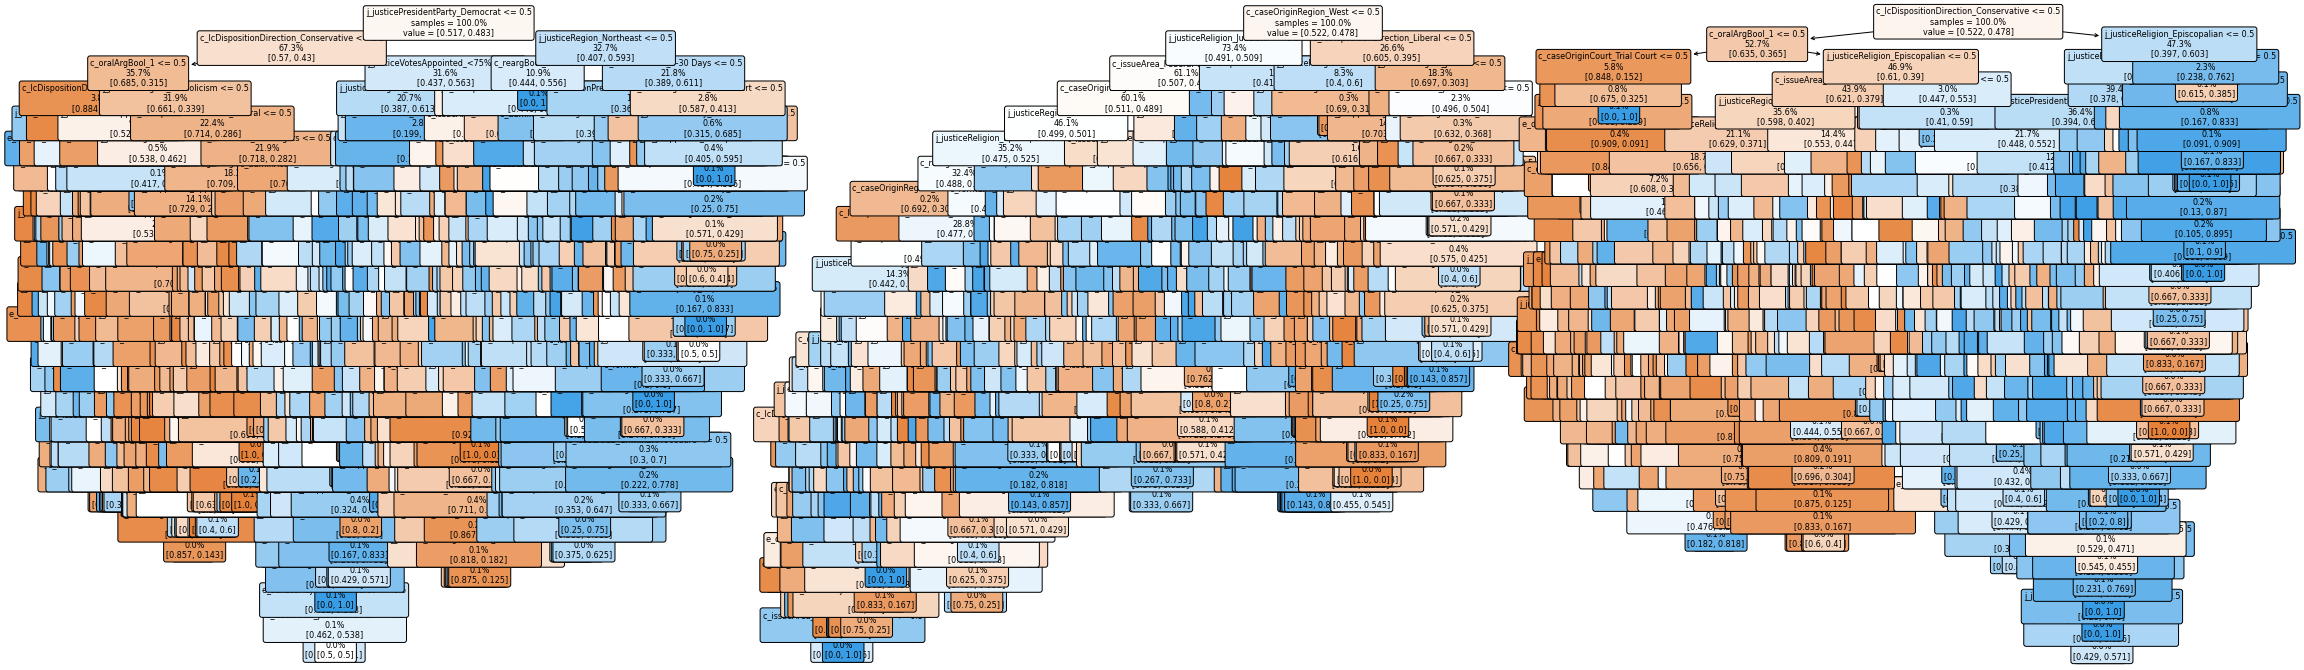

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig, axs = plt.subplots(1,3,figsize=(38,12))
for i, rf_tree in enumerate(rfc.estimators_[0:3]):
    plot_tree(rf_tree, feature_names=X_train.columns.tolist(), impurity=False, label="root",
          filled=True, proportion=True, rounded=True, fontsize=8, ax=axs[i-1])
plt.show()

In [ ]:
rfc.oob_score_
rfc.score(X_test, y_test)
classif_report = classification_report(y_test, rfc.predict(X_test))
print(classif_report)

In [44]:
import time

start_time = time.time()
importances = rfcopt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfcopt.estimators_], axis=0)
elapsed_time = time.time() - start_time

feature_names = sc_df.columns[1:21]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

ValueError: Length of passed values is 72, index implies 20.

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rfcopt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()